## Libraries Import

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from scipy.stats import zscore, mstats, chi2_contingency, f_oneway
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import randint, shapiro, ttest_ind
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

## Dataset Import and Overview

In [2]:
df = pd.read_csv('Customer-Churn-Records.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


## Data Process

### Null values

In [3]:
df.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

There is no null values in this DataFrame.

### Duplicates

In [4]:
duplicated_rows = df.duplicated() 
print('Number of duplicated rows: ', duplicated_rows.sum())

Number of duplicated rows:  0


### Data Types

In [5]:
df.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

### High Correlation Filter

In [6]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname','HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography'], axis=1)

# correlation matrix 
cor_mat = X.corr()

# Bit of crazy numpy. We are getting the triangular matrix 
# the same size as our correlation matrix, with just Trues and 
# Falses, to then use in a mask. (you can just copy paste this though) 
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype('bool')

# Now mask the correlation matrix, keeping only the lower triangle 
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

# Et voila! 
display(cor_mat_lower)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Complain,Point Earned
CreditScore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,-0.003965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,0.000842,-0.009997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balance,0.006268,0.028308,-0.012254,NaN,NaN,NaN,NaN,NaN,NaN
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,NaN,NaN,NaN,NaN,NaN
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,NaN,NaN,NaN,NaN
Exited,-0.026771,0.285296,-0.013656,0.118577,-0.047611,0.012490,NaN,NaN,NaN
Complain,-0.027048,0.283530,-0.013047,0.119124,-0.046357,0.012494,0.995693,NaN,NaN
Point Earned,0.000077,0.002222,-0.010196,0.014608,-0.015330,-0.001515,-0.004628,-0.002893,NaN


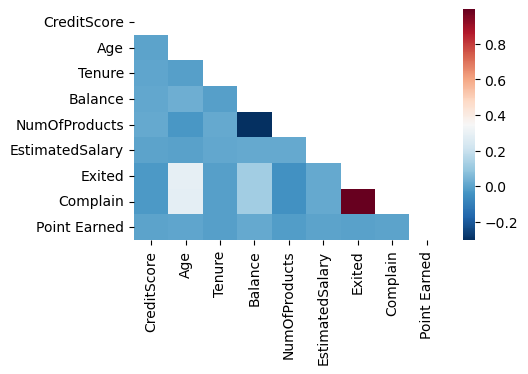

In [7]:
plt.figure(figsize = (5,3)) # <-- just sets the figure size 

sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap 

When analyzing the high correlation of 0.996, between the 'Exited' and 'Complain' variables, it becomes evident that including 'Complain' in the predictive model may be redundant. This is because we are interested in predicting the 'Exited' variable even before any complaints from the customer, aiming to identify the factors contributing to the bank's customer churn. In this context, the presence of a complaint is an obvious indicator of a higher likelihood of churn. Therefore, the decision to remove 'Complain' from the training and testing datasets of the model is justified not only to simplify the model but also to avoid multicollinearity issues and focus on the most relevant variables for the desired prediction. This results in a more effective and interpretable model, capable of providing clear insights into the factors influencing customer churn in the bank.

### Selected Variables

In [8]:
numerical_variables = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned']]
categorical_variables = df[['HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography']]
excluded_variables = df[['RowNumber', 'CustomerId', 'Complain', 'Surname']]
target = df['Exited']

## Descriptive Data Analysis

The '.describe()' method was used to generate descriptive statistics of the numeric variables of the DataFrame. It provides information such as the count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum. This summary helps to understand the distribution and characteristics of the data.

In [9]:
numerical_variables.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1000.000000


## Analysis of the Distribution of Numerical Variables

<Figure size 2000x1200 with 0 Axes>

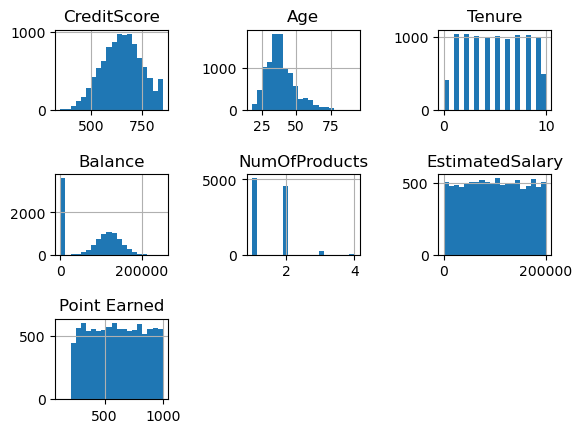

In [10]:
plt.figure(figsize=(20, 12))
numerical_variables.hist(bins=20) 
plt.xticks(rotation=45)  
plt.subplots_adjust(wspace=0.7, hspace=0.8)
plt.show()

## Pre-processing

### Validation Techniques (Train-Test Split)

The dataset is divided into two parts: a training set used to train the model and a separate test set used to evaluate its performance.


In [11]:
X = df.drop(['Exited','RowNumber', 'CustomerId', 'Complain', 'Surname'], axis=1) 
y = df['Exited']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

I separated the training and testing sets after the split based on their variable types: numerical and categorical. I did this to simplify the subsequent preprocessing steps, such as applying one-hot encoding for categorical variables and MinMax normalization for numerical variables.

After applying these preprocessing steps to each set separately, I merged them back into a single training set and a single testing set. This ensured consistency between variables and prepared the data to be fed into a machine learning model.

This approach proved useful because different preprocessing techniques are typically applied to different types of variables. By initially separating the training and testing sets, I could apply these techniques in isolation, avoiding any leakage of information from the testing set to the training set during preprocessing.

In [13]:
X_train_num = X_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned']]

In [14]:
X_train_cat = X_train[['HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography']]

In [15]:
X_test_num = X_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned']]

In [16]:
X_test_cat = X_test[['HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography']]

### Feature Normalization

MinMaxScaler was applied. It is a feature normalization technique widely used in data preprocessing. Its main function is to resize numeric variables values between 0 and 1.

In [17]:
scaler_minmax = MinMaxScaler()
X_train_num = scaler_minmax.fit_transform(X_train_num)
X_test_num = scaler_minmax.transform(X_test_num)


In [18]:
X_train_num_df = pd.DataFrame(X_train_num, columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned'])

In [19]:
X_test_num_df = pd.DataFrame(X_test_num, columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned'])

### One-hot Encoding

One-hot encoding is a popular technique for handling categorical variables. Where each category is transformed into a binary vector (with a value of 1 indicating the presence of that category and 0 indicating absence).
It is particularly useful because it allows machine learning algorithms to work with categorical data, which are typically non-numeric, in a format that they can understand.

In [20]:
encoder = OneHotEncoder(drop='first') 
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

In [21]:
X_train_cat_df = pd.DataFrame(
    X_train_cat.toarray(),
    columns=encoder.get_feature_names_out(['HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography'])
)

In [22]:
X_test_cat_df = pd.DataFrame(
    X_test_cat.toarray(),
    columns=encoder.get_feature_names_out(['HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'Card Type', 'Gender', 'Geography'])
)

### Independent Variables Concatenation (X_train, X_test)

In [23]:
X_train = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

### Imbalanced Dataset Techniques

In real-world scenarios, datasets often exhibit class imbalances, where one class significantly outnumbers the others. This can pose challenges for machine learning models, as they may struggle to effectively learn from the minority class examples, leading to biased predictions.  

To address this issue, various techniques have been developed to balance the dataset distribution. Two common approaches are Tomek Links, which focuses on removing examples from the majority class that are near the decision boundary, and Borderline-SMOTE, which synthesizes new examples for the minority class.  

To determine the most suitable technique for this particular dataset, I applyed these methods and evaluated the performance of XGBClassifier. By comparing metrics like mean absolute error across different techniques, it becomes possible to identify the approach that enhances more accurate predictions.

#### Tomek Links (underfitting)

In [24]:
# define the undersampling method
tom = TomekLinks()

# transform the dataset
X_tom, y_tom = tom.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_tom)
print(counter)

# fit the model
model = XGBClassifier(random_state=42)
model.fit(X_tom, y_tom)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

Counter({0: 5073, 1: 1454})
MAE: 0.139


#### Borderline-SMOTE (overfitting)

In [25]:
# define the undersampling method
bsmt = BorderlineSMOTE()

# transform the dataset
X_bsmt, y_bsmt = bsmt.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_bsmt)
print(counter)

# fit the model
model = XGBClassifier(random_state=42)
model.fit(X_bsmt, y_bsmt)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

Counter({1: 5546, 0: 5546})
MAE: 0.145


### Outlier Detection

Outliers are data points that deviate significantly from the majority of the data, potentially indicating anomalies, errors, or interesting patterns.

To address this challenge, I've explored various outlier detection techniques, among which Isolation Forest and Minimum Covariance Determinant (MCD). Isolation Forest leverages the concept of decision trees to isolate outliers by partitioning the data into subsets, while MCD estimates the parameters of a multivariate Gaussian distribution to identify outliers based on their distance from the center of the data distribution.  

To determine the most suitable outlier detection technique, I applyed these methods and evaluated the performance of XGBClassifier. By comparing metrics like mean absolute error across different techniques, it becomes possible to identify the approach that enhances more accurate predictions.

#### Isolation Forest

In [26]:
# summarize the shape of the training dataset
print(X_tom.shape, y_tom.shape)

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
y_iso = iso.fit_predict(X_tom)

# select all rows that are not outliers
mask = y_iso != -1
X_train_iso, y_train_iso = X_tom[mask], y_tom[mask]

# summarize the shape of the updated training dataset
print(X_train_iso.shape, y_train_iso.shape)

# fit the model
model = XGBClassifier(random_state=42)
model.fit(X_train_iso, y_train_iso)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.10f' % mae)

(6527, 19) (6527,)
(5874, 19) (5874,)
MAE: 0.1433333333


#### Minimum Covariance Determinant

In [27]:
# summarize the shape of the training dataset
print(X_tom.shape, y_tom.shape)

# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.01)
y_ee = ee.fit_predict(X_tom)

# select all rows that are not outliers
mask = y_ee != -1
X_train_ee, y_train_ee = X_tom[mask], y_tom[mask]


# summarize the shape of the updated training dataset
print(X_train_ee.shape, y_train_ee.shape)

# fit the model
model = XGBClassifier(random_state=42)
model.fit(X_train_ee, y_train_ee)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.10f' % mae)

(6527, 19) (6527,)
(6461, 19) (6461,)
MAE: 0.1446666667


## Classification Model

After determining the best technique for handling imbalanced datasets and outlier detection based on the training datasets subjected to these preprocessing methods, I evaluated the performance of four models: Logistic Regression, Random Forest Classifier, Bagging, and eXtreme Gradient Boosting (XGBoost) Classifier.  
The evaluation was based on metrics, including: mean absolute error; accuracy; confusion matrix and classification report (precision, recall, f1-score, support).

### Classification with Logistic Regression

In [28]:
# Initialize the model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train_iso, y_train_iso)

# Threshold for classification
threshold = 0.5

# Predicting probabilities of the positive class for the test data
probs_positive_class = model.predict_proba(X_test)[:, 1]

# Converting probability predictions to binary predictions based on the threshold
predictions = (probs_positive_class > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:\n', accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print('\nConfusion Matrix:\n', conf_matrix)

# Classification report
class_report = classification_report(y_test, predictions)
print('\nClassification Report:\n', class_report)

Accuracy:
 0.817

Confusion Matrix:
 [[2315  101]
 [ 448  136]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89      2416
           1       0.57      0.23      0.33       584

    accuracy                           0.82      3000
   macro avg       0.71      0.60      0.61      3000
weighted avg       0.79      0.82      0.78      3000



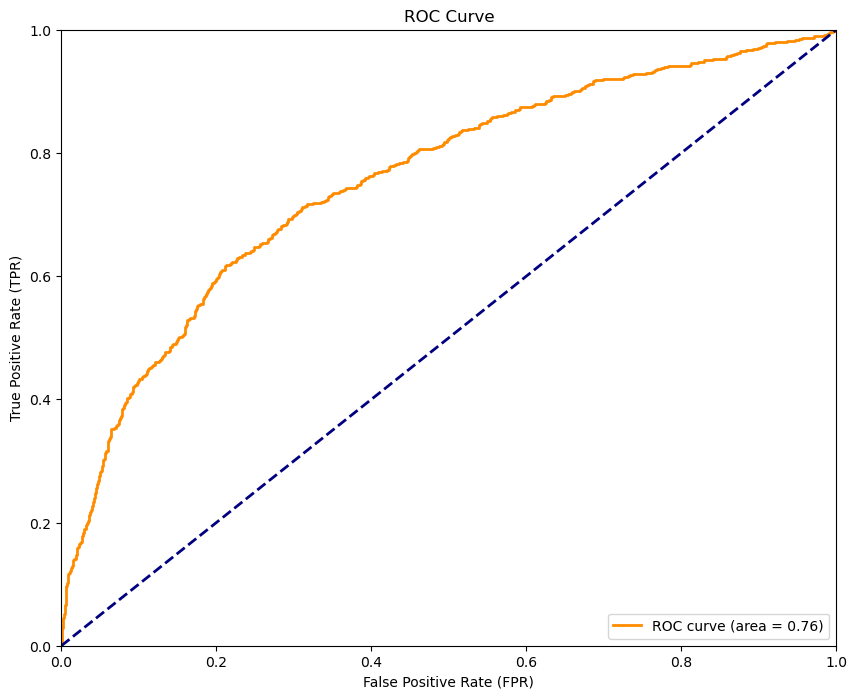

In [29]:
# Predicting probabilities of the positive class for the test data
y_prob = model.predict_proba(X_test)[:, 1]

# Calculating the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculating the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

### Random Forest Classifier

In [30]:
# Initialize the RandomForest classifier model
rfc = RandomForestClassifier(random_state=42)

# Train the model
rfc.fit(X_train_iso, y_train_iso)

# Make predictions
y_pred = rfc.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.10f' % mae)

# Evaluate the model
accuracy = rfc.score(X_test, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

MAE: 0.1313333333
Accuracy: 0.8686666666666667
Confusion Matrix:
[[2332   84]
 [ 310  274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000



### Bagging

In [31]:
# Initialize the Bagging classifier model
bagging = BaggingClassifier(random_state=42)

# Train the model
bagging.fit(X_train_iso, y_train_iso)

# Make predictions
y_pred = bagging.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.10f' % mae)

# Evaluate the model
accuracy_bagging = bagging.score(X_test, y_test)
print("Accuracy:", accuracy_bagging)

# Confusion Matrix
conf_matrix_bagging = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_bagging)

# Classification Report
class_report_bagging = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report_bagging)

MAE: 0.1536666667
Accuracy: 0.8463333333333334
Confusion Matrix:
[[2271  145]
 [ 316  268]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2416
           1       0.65      0.46      0.54       584

    accuracy                           0.85      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.85      0.84      3000



### eXtreme Gradient Boosting (XGBoost) Classifier

In [32]:
# Initialize the XGBoost classifier model
xgboost = XGBClassifier(random_state=42)

# Train the model
xgboost.fit(X_train_iso, y_train_iso, verbose = False)

# Make predictions
y_pred = xgboost.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.10f' % mae)

# Evaluate the model
accuracy_xgboost = xgboost.score(X_test, y_test)
print("Accuracy:", accuracy_xgboost)

# Confusion Matrix
conf_matrix_xgboost = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_xgboost)

# Classification Report
class_report_xgboost = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report_xgboost)

MAE: 0.1433333333
Accuracy: 0.8566666666666667
Confusion Matrix:
[[2262  154]
 [ 276  308]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2416
           1       0.67      0.53      0.59       584

    accuracy                           0.86      3000
   macro avg       0.78      0.73      0.75      3000
weighted avg       0.85      0.86      0.85      3000



## Feature Selection

### Feature Importance

It refers to understanding the contribution of each input feature (variable) to the prediction made by a model. It helps in identifying which features have the most influence on the model's output and can provide valuable insights.

In [33]:
rfc.feature_importances_

array([0.09972904, 0.2117045 , 0.0631322 , 0.11080251, 0.09207139,
       0.10585587, 0.1053094 , 0.01672503, 0.04032831, 0.01321519,
       0.01284949, 0.01287907, 0.01299584, 0.01325214, 0.01391487,
       0.01488715, 0.01797507, 0.02980835, 0.01256455])

Text(0, 0.5, 'Feature')

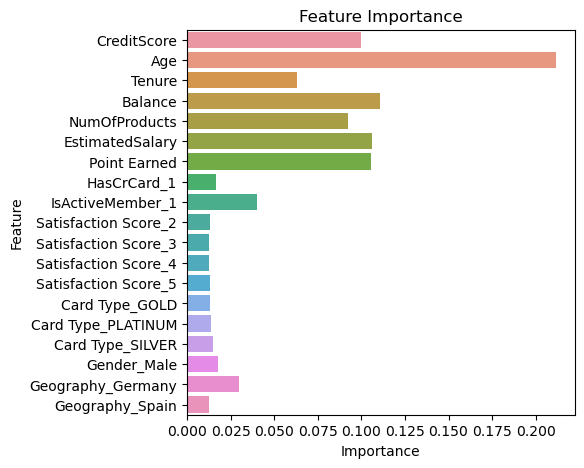

In [34]:
# Define size of bar plot
plt.figure(figsize=(5,5))

# Plot Searborn bar chart
sns.barplot(x=rfc.feature_importances_, y=X_train.columns)

# Add chart labels
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature') 

I removed all variables with an importance score below 0.025.

In [35]:
X_train_feature_selected = X_train_iso.drop(columns=['HasCrCard_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
       'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD',
       'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male',
       'Geography_Spain',])
X_test_feature_selected = X_test.drop(columns=['HasCrCard_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
       'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD',
       'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male',
       'Geography_Spain',])

I adapted it to the Random Forest and XGBoost classifiers to understand if better results could be achieved.

#### Random Forest Classifier (with Feature Importance)

In [36]:
# Train the model
rfc.fit(X_train_feature_selected ,y_train_iso)

# Make predictions
y_pred_feature_selected = rfc.predict(X_test_feature_selected)

# Evaluate predictions
mae_feature_selected = mean_absolute_error(y_test, y_pred_feature_selected)
print('MAE: %.10f' % mae_feature_selected)

# Evaluate the model
accuracy = rfc.score(X_test_feature_selected, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_feature_selected)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_feature_selected)
print("\nClassification Report:")
print(class_report)

MAE: 0.1386666667
Accuracy: 0.8613333333333333
Confusion Matrix:
[[2298  118]
 [ 298  286]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.71      0.49      0.58       584

    accuracy                           0.86      3000
   macro avg       0.80      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



#### XGBoost Classifier (with Feature Importance)

In [37]:
# Train the model
xgboost.fit(X_train_feature_selected ,y_train_iso)

# Make predictions
y_pred_feature_selected = xgboost.predict(X_test_feature_selected)

# Evaluate predictions
mae_feature_selected = mean_absolute_error(y_test, y_pred_feature_selected)
print('MAE: %.10f' % mae_feature_selected)

# Evaluate the model
accuracy = xgboost.score(X_test_feature_selected, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_feature_selected)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_feature_selected)
print("\nClassification Report:")
print(class_report)

MAE: 0.1450000000
Accuracy: 0.855
Confusion Matrix:
[[2274  142]
 [ 293  291]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2416
           1       0.67      0.50      0.57       584

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.85      3000



In this specific situation, removing features with less importance did not have much influence on improving the performance of the predictive models.

### Backward Feature Selection

Backward Feature Selection is a technique used to select the most relevant set of features. This approach starts with the full set of features and then iteratively removes the least important ones one by one until a stopping criterion is reached.

In [38]:
sfs = SequentialFeatureSelector(rfc, k_features=4, forward=False, verbose=1, scoring='neg_mean_squared_error')

sfs.fit(X_train_iso, y_train_iso)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.2min finished
Features: 18/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished
Features: 17/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   56.7s finished
Features: 16/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   47.3s finished
Features: 15/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   45.1s finished
Features: 14/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   46.8s finished
Features: 13/4[Parallel(

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          forward=False, k_features=(4, 4),
                          scoring='neg_mean_squared_error', verbose=1)

In [39]:
X_train_iso.dtypes

CreditScore             float64
Age                     float64
Tenure                  float64
Balance                 float64
NumOfProducts           float64
EstimatedSalary         float64
Point Earned            float64
HasCrCard_1             float64
IsActiveMember_1        float64
Satisfaction Score_2    float64
Satisfaction Score_3    float64
Satisfaction Score_4    float64
Satisfaction Score_5    float64
Card Type_GOLD          float64
Card Type_PLATINUM      float64
Card Type_SILVER        float64
Gender_Male             float64
Geography_Germany       float64
Geography_Spain         float64
dtype: object

In [40]:
feat_names_sfs = list(sfs.k_feature_names_)
print(feat_names_sfs)

['Age', 'Balance', 'NumOfProducts', 'IsActiveMember_1']


In [41]:
# drop of columns that were not selected.

X_train_sfs = X_train_iso.drop(columns=['CreditScore', 'Balance', 'EstimatedSalary', 'Point Earned', 'HasCrCard_1', 
                'IsActiveMember_1', 'Satisfaction Score_2', 'Satisfaction Score_3', 
                'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD', 
                'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male', 'Geography_Spain'])
X_test_sfs = X_test.drop(columns=['CreditScore', 'Balance', 'EstimatedSalary', 'Point Earned', 'HasCrCard_1', 
                'IsActiveMember_1', 'Satisfaction Score_2', 'Satisfaction Score_3', 
                'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD', 
                'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male', 'Geography_Spain'])


I adapted it to the Random Forest and XGBoost classifiers to understand if better results could be achieved.

#### RandomForestClassifier

In [42]:
# Train the model
rfc.fit(X_train_sfs ,y_train_iso)

# Make predictions
y_pred_sfs = rfc.predict(X_test_sfs)

# Evaluate predictions
mae_sfs = mean_absolute_error(y_test, y_pred_sfs)
print('MAE: %.10f' % mae_sfs)

# Evaluate the model
accuracy = rfc.score(X_test_sfs, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix_sfs = confusion_matrix(y_test, y_pred_sfs)
print("Confusion Matrix:")
print(conf_matrix_sfs)

# Classification Report
class_report_sfs = classification_report(y_test, y_pred_sfs)
print("\nClassification Report:")
print(class_report_sfs)

MAE: 0.1750000000
Accuracy: 0.825
Confusion Matrix:
[[2210  206]
 [ 319  265]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2416
           1       0.56      0.45      0.50       584

    accuracy                           0.82      3000
   macro avg       0.72      0.68      0.70      3000
weighted avg       0.81      0.82      0.82      3000



#### eXtreme Gradient Boosting (XGBoost)

In [43]:
# Train the model
xgboost.fit(X_train_sfs ,y_train_iso)

# Make predictions
y_pred_sfs = xgboost.predict(X_test_sfs)

# Evaluate predictions
mae_sfs = mean_absolute_error(y_test, y_pred_sfs)
print('MAE: %.10f' % mae_sfs)

# Evaluate the model
accuracy = xgboost.score(X_test_sfs, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix_sfs = confusion_matrix(y_test, y_pred_sfs)
print("Confusion Matrix:")
print(conf_matrix_sfs)

# Classification Report
class_report_sfs = classification_report(y_test, y_pred_sfs)
print("\nClassification Report:")
print(class_report_sfs)

MAE: 0.1586666667
Accuracy: 0.8413333333333334
Confusion Matrix:
[[2249  167]
 [ 309  275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2416
           1       0.62      0.47      0.54       584

    accuracy                           0.84      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



### Forward Feature Selection

Unlike 'Backward Feature Selection', which starts with all features and iteratively removes them, 'Forward Feature Selection' starts with an empty set of features and adds them one by one, evaluating the model's performance at each step.  
They are considered 'greedy' algorithms, because they make the decision to remove/add the least important feature at each step, based only on the information available at that time, without considering the overall impact of feature removal/add.

In [44]:
ffs = SequentialFeatureSelector(rfc, k_features=4, forward=True, verbose=1, scoring='neg_mean_squared_error')

ffs.fit(X_train_iso, y_train_iso)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   29.8s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   27.1s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   28.1s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   28.9s finished
Features: 4/4

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          k_features=(4, 4), scoring='neg_mean_squared_error',
                          verbose=1)

In [45]:
feat_names_ffs = list(ffs.k_feature_names_)
print(feat_names_ffs)

['Age', 'NumOfProducts', 'IsActiveMember_1', 'Satisfaction Score_3']


In [46]:
# drop of columns that were not selected.

X_train_ffs = X_train_iso.drop(columns=['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned', 
                'HasCrCard_1', 'Satisfaction Score_2', 'Satisfaction Score_3', 
                'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD', 
                'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male', 'Geography_Spain'])
X_test_ffs = X_test.drop(columns=['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned', 
                'HasCrCard_1', 'Satisfaction Score_2', 'Satisfaction Score_3', 
                'Satisfaction Score_4', 'Satisfaction Score_5', 'Card Type_GOLD', 
                'Card Type_PLATINUM', 'Card Type_SILVER', 'Gender_Male', 'Geography_Spain'])

I adapted it to the Random Forest and XGBoost classifiers to understand if better results could be achieved.

#### RandomForestClassifier

In [47]:
# Train the model
rfc.fit(X_train_ffs ,y_train_iso)

# Make predictions
y_pred_ffs = rfc.predict(X_test_ffs)

# Evaluate predictions
mae_ffs = mean_absolute_error(y_test, y_pred_ffs)
print('MAE: %.10f' % mae_ffs)

# Evaluate the model
accuracy_ffs = rfc.score(X_test_ffs, y_test)
print("Accuracy:", accuracy_ffs)

# Confusion Matrix
conf_matrix_ffs = confusion_matrix(y_test, y_pred_ffs)
print("Confusion Matrix:")
print(conf_matrix_ffs)

# Classification Report
class_report_ffs = classification_report(y_test, y_pred_ffs)
print("\nClassification Report:")
print(class_report_ffs)

MAE: 0.1406666667
Accuracy: 0.8593333333333333
Confusion Matrix:
[[2303  113]
 [ 309  275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2416
           1       0.71      0.47      0.57       584

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



#### eXtreme Gradient Boosting (XGBoost)

In [48]:
# Train the model
xgboost.fit(X_train_ffs ,y_train_iso)

# Make predictions
y_pred_ffs = xgboost.predict(X_test_ffs)

# Evaluate predictions
mae_ffs = mean_absolute_error(y_test, y_pred_ffs)
print('MAE: %.10f' % mae_ffs)

# Evaluate the model
accuracy_ffs = xgboost.score(X_test_ffs, y_test)
print("Accuracy:", accuracy_ffs)

# Confusion Matrix
conf_matrix_ffs = confusion_matrix(y_test, y_pred_ffs)
print("Confusion Matrix:")
print(conf_matrix_ffs)

# Classification Report
class_report_ffs = classification_report(y_test, y_pred_ffs)
print("\nClassification Report:")
print(class_report_ffs)

MAE: 0.1376666667
Accuracy: 0.8623333333333333
Confusion Matrix:
[[2301  115]
 [ 298  286]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.71      0.49      0.58       584

    accuracy                           0.86      3000
   macro avg       0.80      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



Forward Feature Selection slightly increased the accuracy of each class in the model (0 and 1), but there was no improvement in the other metrics. On the other hand, in the case of the Backward Feature Selection, there was a decrease in the accuracy of each class. Therefore, in this specific case, the Forward Feature Selection could be a potential approach to improve the model, unlike the Backward Feature Selection.

## Hyperparameter Tuning

The goal of 'hyperparameter tuning' is to find the best combination of values that optimizes model performance. By adjusting the hyperparameters appropriately, it is possible to significantly improve the model's performance. In this case, 'hyperparameter tuning' will be performed for XGBoost and Random Forest Classifier.  
'RandomizedSearchCV' was the option chosen to perform the hyperparameter search, as it is computationally more dynamic and at the same time efficient.

### RandomForestClassifier

In [49]:
param_distributions = {
    'n_estimators': list(range(100, 1001)),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

In [50]:
randomized_search = RandomizedSearchCV(
    estimator=rfc,  
    param_distributions = param_distributions,  
    cv=5,  #
    n_iter=10, 
    scoring="recall",  
    return_train_score=True  
)

In [51]:
randomized_search.fit(X_train_iso, y_train_iso)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...]},
                   return_train_score=True, scoring='recall')

In [52]:
randomized_search.best_estimator_

RandomForestClassifier(bootstrap=False, n_estimators=128, random_state=42)

In [53]:
randomized_search.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 128,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
randomized_search.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [55]:
randomized_search.best_params_

{'n_estimators': 128,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

In [56]:
randomized_search.best_score_

0.4499131298088856

In [100]:
# these determined 'params' are better. 

params = {'n_estimators': 591,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

In [99]:
# Initialize the model
rfc = RandomForestClassifier(**params, random_state=42)

# cross_validate was used to evaluate model performance on different folds of the training data during the training phase.
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
scores = cross_validate(rfc, X_train_iso, y_train_iso, cv=5, scoring=scoring)

for metric, values in scores.items():
    print(f"{metric}: {scores[metric].mean()} (±{scores[metric].std()})")
    
# Train the model Random Forest Classifier
rfc.fit(X_train_iso, y_train_iso)

# Make predictions
y_pred = rfc.predict(X_test)

# Evaluate the model
accuracy = rfc.score(X_test, y_test)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

fit_time: 4.33214693069458 (±0.04903961489170026)
score_time: 0.15383987426757811 (±0.007571737788829479)
test_accuracy: 0.8614225959621586 (±0.003955590084258195)
test_precision: 0.777842453429754 (±0.01810217716503202)
test_recall: 0.4431904407332553 (±0.03942792356577964)
test_f1: 0.5631418277594451 (±0.028128217710261357)
Accuracy: 0.87
Confusion Matrix:
[[2322   94]
 [ 296  288]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.75      0.49      0.60       584

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In [61]:
scores

{'fit_time': array([4.49639535, 4.38728738, 4.27385116, 4.56781387, 4.27947855]),
 'score_time': array([0.16112566, 0.15301633, 0.16669774, 0.14749646, 0.14175296]),
 'test_accuracy': array([0.86042553, 0.8587234 , 0.8612766 , 0.86893617, 0.85775128]),
 'test_precision': array([0.7890625 , 0.78571429, 0.74509804, 0.77272727, 0.79661017]),
 'test_recall': array([0.42436975, 0.41596639, 0.4789916 , 0.5       , 0.39662447]),
 'test_f1': array([0.55191257, 0.54395604, 0.5831202 , 0.60714286, 0.52957746])}

### eXtreme Gradient Boosting (XGBoost)

In [62]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500, 1000],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [63]:
randomized_search = RandomizedSearchCV(
    estimator=xgboost,  
    param_distributions = param_grid,  
    cv=5,  #
    n_iter=10, 
    scoring= "accuracy",  
    return_train_score=True  
)

In [64]:
randomized_search.fit(X_train_iso, y_train_iso)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   return_train_score=True, scoring='accuracy')

In [65]:
randomized_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [66]:
randomized_search.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.1,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1.0,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [67]:
randomized_search.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
randomized_search.best_params_

{'subsample': 1.0,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

In [94]:
xgboost_params= {'subsample': 1.0,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

In [91]:
randomized_search.best_score_

0.8588695494581173

In [95]:
# Initialize the model
xgboost = XGBClassifier(**xgboost_params, random_state=42)

# Train the model
xgboost.fit(X_train_iso, y_train_iso, verbose = False)

# Make predictions
y_pred = xgboost.predict(X_test)

# Evaluate the model
accuracy_xgboost = xgboost.score(X_test, y_test)
print("Accuracy:", accuracy_xgboost)

# Confusion Matrix
conf_matrix_xgboost = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_xgboost)

# Classification Report
class_report_xgboost = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report_xgboost)

Accuracy: 0.8683333333333333
Confusion Matrix:
[[2323   93]
 [ 302  282]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.75      0.48      0.59       584

    accuracy                           0.87      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000



## Statistical Tests

#### Normality Test

If the p-value is greater than the alpha significance level (0.05), then the null hypothesis is not rejected and it is concluded that the data is probably normally distributed. Otherwise, if the p-value is less than alpha, the null hypothesis is rejected and it is concluded that the data is not normally distributed.

In [83]:
data = X_train

# Perform Shapiro-Wilk normality test
stat, p = stats.shapiro(data)

# Print test results
print('Shapiro-Wilk test statistic: %.3f' % stat)
print('p-value: %.3f' % p)

# Interpret test results
alpha = 0.05
if p > alpha:
    print('The data is likely normally distributed (fail to reject H0)')
else:
    print('The data is likely not normally distributed (reject H0)')

Shapiro-Wilk test statistic: 0.757
p-value: 0.000
The data is likely not normally distributed (reject H0)


### Student's Two Sample T-test

Based on the p-value (p) in relation to the alpha significance level (0.05), the null hypothesis (H0) that there is no significant difference between the means of the two samples is tested. If the p-value is greater than alpha, the null hypothesis is not rejected, indicating that the difference between the means of the two samples is not significant. Otherwise, if the p-value is less than alpha, the null hypothesis is rejected, indicating that there is a significant difference between the means of the two samples.

In [84]:
# Example datasets
sample1 = X_train['EstimatedSalary']
sample2 = X_train['IsActiveMember_1']

# Perform Student t-test
t, p = stats.ttest_ind(sample1, sample2)

# Print test results
print('Student t-test statistic: %.3f' % t)
print('p-value: %.3f' % p)

# Interpret test results
alpha = 0.05
if p > alpha:
    print('The difference between the means of the two samples is not significant (fail to reject H0)')
else:
    print('The difference between the means of the two samples is significant (reject H0)')

Student t-test statistic: -1.577
p-value: 0.115
The difference between the means of the two samples is not significant (fail to reject H0)


### Chi-Squared Correlation Test

If the p-value is less than or equal to alpha (0.05), we reject the null hypothesis (H0) and conclude that the variables are dependent. Otherwise, if the p-value is greater than alpha, we fail to reject the null hypothesis and conclude that the variables are independent (dependent/independent, meaning that there is/is no significant association between them in the population, i.e., the two variables do not are related and in the case of varying in one variable it does not affect the probability of observing a specific behavior in the other variable).

In [85]:
#define the contingency table
contigency = pd.crosstab(X_train['EstimatedSalary'], X_train['Card Type_PLATINUM'])
display(contigency)

stat, p, dof, expected = chi2_contingency(contigency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

Card Type_PLATINUM,0.0,1.0
EstimatedSalary,,
0.000000,1,0
0.000008,1,0
0.000031,1,0
0.000441,1,0
0.000631,1,0
...,...,...
0.999433,1,0
0.999460,1,0
0.999693,1,0


p value is 0.4999058774168547
Independent (H0 holds true)


### ANOVA 

If the p-value is less than alpha (0.05), it prints out that there is a statistically significant difference between the groups; otherwise, it prints out that there is not enough evidence to reject the null hypothesis (H0) that the groups have the same mean.  
"Statistically significant difference", indicates that the observed difference is considered not to be the result of random variation in the data, but rather as an indication of a true difference between the groups.

In [86]:
performance1 = X_train['CreditScore']
performance2 = X_train['EstimatedSalary']
performance3 = X_train['Tenure']
performance4 = X_train['NumOfProducts']
 
# Conduct the one-way ANOVA
f_statistic, p_value = f_oneway(performance1, performance2, performance3, performance4)

# Display the results
print('F-statistic:', f_statistic)
print('p-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('There is a statistically significant difference between the groups.')
else:
    print('There is not enough evidence to reject the null hypothesis that the groups have the same mean.')

F-statistic: 4059.824999987538
p-value: 0.0
There is a statistically significant difference between the groups.
